In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import seaborn as sns

In [ ]:
# Load data
df = pd.read_csv("/content/students_habit_predict_mental_health.csv")
X = df.drop(columns=["Unnamed: 0", "mental_health_rating"])
y = df["mental_health_rating"]

In [ ]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
# 1. Gradient Boosting + Tuning
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5]
}
grid_search = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid, cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1, verbose=1
)
grid_search.fit(X_train_scaled, y_train)
best_gbr = grid_search.best_estimator_

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


In [ ]:
# 2. XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
# 3. Stacking Regressor
stacking_model = StackingRegressor(
    estimators=[
        ('gb', best_gbr),
        ('rf', RandomForestRegressor(random_state=42)),
        ('xgb', xgb_model)
    ],
    final_estimator=Ridge()
)
stacking_model.fit(X_train_scaled, y_train)

StackingRegressor(estimators=[('gb',
                               GradientBoostingRegressor(learning_rate=0.05,
                                                         min_samples_split=10,
                                                         n_estimators=500,
                                                         random_state=42)),
                              ('rf', RandomForestRegressor(random_state=42)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=No...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))],
                  final_estimator=Ridge())

In [ ]:
# Predict
y_gbr_pred = best_gbr.predict(X_test_scaled)
y_xgb_pred = xgb_model.predict(X_test_scaled)
y_stack_pred = stacking_model.predict(X_test_scaled)

In [ ]:
# Feature importance từ best_gbr
importances = best_gbr.feature_importances_
top7_indices = np.argsort(importances)[::-1][:7]
top7_features = X.columns[top7_indices]

In [ ]:
# Dùng top features
X_top = X[top7_features]
X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(X_top, y, test_size=0.2, random_state=42)
X_train_top_scaled = scaler.fit_transform(X_train_top)
X_test_top_scaled = scaler.transform(X_test_top)
best_gbr.fit(X_train_top_scaled, y_train_top)
y_top_pred = best_gbr.predict(X_test_top_scaled)

In [ ]:
# Evaluate
def eval_model(name, y_true, y_pred):
    print(f"\n{name}")
    print("MSE:", mean_squared_error(y_true, y_pred))
    print("R²:", r2_score(y_true, y_pred))

eval_model("GradientBoosting (Tuned)", y_test, y_gbr_pred)
eval_model("XGBoost", y_test, y_xgb_pred)
eval_model("StackingRegressor", y_test, y_stack_pred)
eval_model("Top 7 Features (GBR)", y_test_top, y_top_pred)



GradientBoosting (Tuned)
MSE: 4.593075777298367
R²: 0.4268971130342426

XGBoost
MSE: 5.407207012176514
R²: 0.32531362771987915

StackingRegressor
MSE: 4.617904855480398
R²: 0.4237990547663708

Top 7 Features (GBR)
MSE: 4.352915692695602
R²: 0.4568631846806247


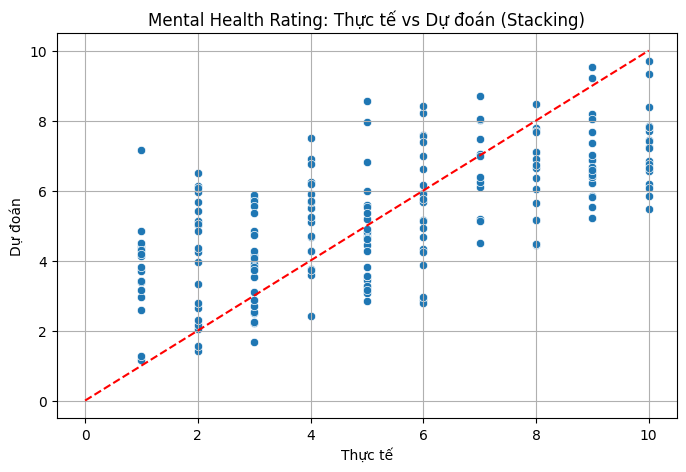

In [ ]:
# Visualize: thực tế vs dự đoán tốt nhất
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_stack_pred)
plt.plot([0, 10], [0, 10], 'r--')
plt.xlabel("Thực tế")
plt.ylabel("Dự đoán")
plt.title("Mental Health Rating: Thực tế vs Dự đoán (Stacking)")
plt.grid(True)
plt.show()